In [68]:
import spacy, pandas, numpy, string
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import os.path
import math

In [69]:
# LOAD DATA
def load_data(path):
    
    data_raw = open(path + '_distr.csv', encoding = 'utf-8').read()
    data_list = data_raw.split('\n') # this leaves an empty last line in the table
    input_table = [row.split(';') for row in data_list]
    
#    print('data load from ' + path + ' is done')
    return input_table  

In [70]:
# EXTRACT DOMINANT TOPIC AND RECORDS FROM DATASET
def extract_data(input_table):
    
    work_table = []
    for i in range(1, len(input_table)-1):   
        topic_vector = []
        for j in range(12, len(input_table[i])-1):
            if input_table[i][j] != '"':
                topic_vector.append(float(input_table[i][j].replace('"', '')))
            # FORMAT EXAMPLE: ['ROW_ID', 'RECORD', 'DOMINANT TOPIC', 'TOPIC VECTOR']
        work_table.append([input_table[i][0], input_table[i][1], input_table[i][len(input_table[i])-1], topic_vector])   

#    print('data extraction done')
    return work_table

In [71]:
# GROUP TRANSCRIPTIONS BY DOMINANT TOPIC
# CLUSTER FORMAT, EXAMPLE: ['DOMINANT TOPIC', 'TOPIC VECTOR', 'RECORD']
# CLUSTER FORMAT, EXAMPLE: ['1', '0., 0.27, 0.41', 'mhm ja zürich']
def create_clusters(work_table):  
    
    # CREATE AGGREGATION LEVELS
    topics = []
    for i in range(0, len(work_table)-1):
        if work_table[i][2] not in topics:
            topics.append(work_table[i][2])

    clusters = [[dominant_topic, [], []] for dominant_topic in topics]
   
    # SPLIT INTO CLUSTERS
    for i in range(0, len(work_table)-1):
        for j in range (0, len(clusters)):
            if (clusters[j][0] == work_table[i][2]):
                clusters[j][1].append(numpy.asarray(work_table[i][3]))
                clusters[j][2].append(work_table[i][1])

#    print('clusters done')
    return clusters

In [72]:
# EXTRACT TERMS AND WEIGHTS PER TOPIC
# TERMS_ONLY EXAMPLE: [['danken', 'fallen', 'dienstag', 'frank', 'bitten'], ['warten', 'dürfen', 'abend', 'woche', 'tagen'], ['kennen', 'spielen', 'lernen', 'easy', 'echt']]
# TERMS_WITH_WEIGHT EXAMPLE: [{'danken': '86.285', 'fallen': '78.262', 'dienstag': '68.248', 'frank': '62.249', 'bitten': '57.422'}, {'warten': '85.251', ...]
def extract_topics(path_topics):

    # LOAD
    topics_raw = open(path_topics + '_topics.csv', encoding = 'latin-1').read()
    topics_list = topics_raw.split('\n')
    topics_table = [topic.replace('(', ',').replace(')', ',').replace(' ', '').split(',') for topic in topics_list]
    
    topics_cleaned = []
    for topic in topics_table:
        cleaned = []
        for i in range(1, len(topic)):
            if (topic[i] != ''):
                cleaned.append(topic[i])
        topics_cleaned.append(cleaned)

    # EXTRACT
    terms_only = []
    terms_with_weight = []
    for i in range(0, len(topics_cleaned)-1):
        term_weight_dict = {}
        terms = []
        for j in range (0, len(topics_cleaned[i])-1):
            if j % 2 == 0:
                terms.append(topics_cleaned[i][j])
                term_weight_dict[topics_cleaned[i][j]] = float(topics_cleaned[i][j + 1])
        terms_only.append(terms)
        terms_with_weight.append(term_weight_dict)
        
#    print('topic extraction done')
    return terms_only, terms_with_weight

In [73]:
# CREATES VOCABULARY OF RECORDS
def read_vocab(file):
    data = open(file, encoding = 'utf-8').read()
    data_list = data.split('\n')
    vocab = set()
    for row in data_list:
        words = row[0 : row.find(';')]
        [vocab.add(word) for word in words.split(' ') if len(word) > 0]
    
    return list(vocab) # use list to have a fixed order of elements (order not important, just that it is fixed)

In [74]:
# ELBOW METHOD USING COSINE SIMILARITY OF TOPIC DISTRIBUTION VECTOR
# Source: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html 
def calculate_cosine_distr (clusters):  
    
    # MEASURE COSINE SIMILARITY BASED ON TOPIC DISTRIBUTION VECTORS
    avg = []
    for c in range(0, len(clusters)):
        vectors = numpy.asarray(clusters[c][1])
        cs = cosine_similarity(vectors)
        avg.append(numpy.average(cs))
        
    # CALCULATE MODEL AVERAGE
    average = numpy.average(numpy.asarray(avg))
    
#    print('cosine similarity calculated')
    return average

In [75]:
# ELBOW METHOD USING COSINE SIMILARITY OF DOCUMENT VECTOR
# Source: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html 
def calculate_cosine_doc (clusters, vocabulary):  
    
    # MEASURE COSINE SIMILARITY BASED ON DOCUMENT VECTORS
    avg = []
    for cluster in clusters:
        if (cluster[0] != 0): # ignore docs without dominant topic
            vectors = []
            for word_string in cluster[2]:
                word_list = [w for w in word_string.split(' ') if len(w) > 0]
                # create a vector of word counts, 1 entry for each word in the vocabulary
                # equals to TF when used in calc. cosine similarity
                word_vector = []
                for w in vocabulary:
                    word_vector.append(word_list.count(w))
                vectors.append(word_vector)

#            vectors = numpy.asarray(clusters[c][1])
            cs = cosine_similarity(vectors)
            avg.append(numpy.average(cs))
        
    # CALCULATE MODEL AVERAGE
    if len(avg) > 0:
        average = numpy.average(numpy.asarray(avg))
    else:
        average = 0
    
#    print('cosine similarity calculated')
    return average

In [76]:
# CALCULATE SEMANTIC COHERENCE
# Source: Mimno et al. 2011
def calculate_coherence(work_table, work_topics):

    #COUNT HOW MANY TIMES EACH WORD PAIR / TOPIC OCCUR TOGETHER IN DOCUMENTS
    avg = []
    for topic in range(0, len(work_topics)): 
        coherence = 0
        for m in range(0, len(work_topics[0])-1):   
            co_doc_frequency = 0     
            for l in range (m + 1, len(work_topics[0])):
                term2_frequency = 0.01
                for row in range(0, len(work_table)):
                    if (work_topics[topic][l] in work_table[row][1]):
                        term2_frequency += 1
                    if (work_topics[topic][m] in work_table[row][1] and work_topics[topic][l] in work_table[row][1]):
                        co_doc_frequency += 1
            coherence += numpy.log((co_doc_frequency + 1) / term2_frequency)
        avg.append(coherence) 

    # CALCULATE MODEL AVERAGE
    average = numpy.average(numpy.asarray(avg))

#    print('coherence calculated')  
    return average

In [77]:
# CALCULATE EXCLUSIVITY
def calculate_exclusivity(terms_with_weight):

    # CALCULATE TERM WEIGHT IN A TOPIC COMPARED TO TERM WEIGHT IN ALL TOPICS
    avg = []
    for topic in terms_with_weight:
        exclusivity = 0.00
        for term, weight in topic.items():
            term_weight_in_all_topics = 0.00
            for topic_for_calc in terms_with_weight:
                if topic_for_calc.get(term) != None:
                    term_weight_in_all_topics += topic_for_calc[term]
            exclusivity += weight / term_weight_in_all_topics 
        avg.append(exclusivity / len(topic.items()))
    
    # CALCULATE MODEL AVERAGE
    average = numpy.average(numpy.asarray(avg))     

#    print('exclusivity calculated')  
    return average

In [78]:
# EXECUTE, 1 PLOT DISPLAYS 4 MODELS ON TOP OF EACH OTHER
def evaluate_nmf(max_dfs, min_dfs, models, n_topic_min, n_topic_max, n_topic_step, folder, cosine_basis):
    
    if cosine_basis == True:
        # READ VOCABULARY
        vocabulary = read_vocab('./IO_YO/all_2Snorm.csv')
        
    # INITIATE GRID PLOT (3X6)
    num_cols = 3 # number of plot columns, equals to evaluation criteria (e.g. exclusivity) for topic models
    num_rows = len(max_dfs)*len(min_dfs) # number of plot rows

    fig = plt.figure(constrained_layout=True, figsize=(num_cols*6.4, num_rows*4.8)) # add spacing and make it large (size in inches)
    spec = fig.add_gridspec(ncols=num_cols, nrows=num_rows)
    current_plot_row = 0
    
    n_topics_range = range(n_topic_min, n_topic_max + 1, n_topic_step)
    cos_x_range = n_topics_range
    if cos_x_range[0] < 2:
        del cos_x_range[0]

    for max_df in max_dfs:
        for min_df in min_dfs:
        
            big_cosine_list = []
            big_coherence_list = []
            big_exclusivity_list = []
            big_no_dominant_list = []
            big_cosine_labels = []     
            big_coherence_labels = []   
            big_exclusivity_labels = [] 
            big_no_dominant_labels = []

            for model in models:
        
                elbow_cosine_list = []     
                elbow_coherence_list = []   
                elbow_exclusivity_list = [] 
                elbow_no_dominant_list = []

                for n_topics in n_topics_range:
            
                    print('in current iteration, model=' + model + ', min_df=' + str(min_df) + ', max_df=' + str(max_df) + ', number of topics=' + str(n_topics))
                    path = folder + model + '_min' + str(min_df) + '_max' + str(max_df) + '_k' + str(n_topics)

                    work_table = extract_data(load_data(path))
                    terms_only, terms_with_weight = extract_topics(path) 
                    clusters = create_clusters(work_table)
                
                    # CALCULATE COSINE SIMILARITY
                    if n_topics >= 2 :
                        if cosine_basis == True:
                            average_cosine = calculate_cosine_doc(clusters, vocabulary)  
                        else:
                            average_cosine = calculate_cosine_distr(clusters)   
                        elbow_cosine_list.append(average_cosine)

                    # CALCULATE COHERENCE  
                    average_coherence = calculate_coherence(work_table, terms_only)
                    elbow_coherence_list.append(average_coherence)
    
                    # CALCULATE EXCLUSIVITY
                    average_exclusivity = calculate_exclusivity(terms_with_weight)
                    elbow_exclusivity_list.append(average_exclusivity)    

                    # CALCULATE THE NUMBER OF DOCUMENTS WITHOUT DOMINANT TOPIC
                    if n_topics >= 3 :
                        for cluster in clusters:
                            if cluster[0] == '0':
                                nr_docs_without_dominant_topic = len(cluster[1]) 
                                elbow_no_dominant_list.append(nr_docs_without_dominant_topic)
                

                big_cosine_list.append(elbow_cosine_list)
                big_coherence_list.append(elbow_coherence_list)
                big_exclusivity_list.append(elbow_exclusivity_list) 
                big_no_dominant_list.append(elbow_no_dominant_list)
                big_cosine_labels.append(model)
                big_coherence_labels.append(model)
                big_exclusivity_labels.append(model)  
                big_no_dominant_labels.append(model)

            # VISUALIZE COSINE SIMILARITY  
            subplt = fig.add_subplot(spec[current_plot_row, 0])
            for i in range(0, len(big_cosine_list)):
                subplt.plot(
                    cos_x_range,
                    big_cosine_list[i],
                    label = big_cosine_labels[i])
            subplt.set_title('cosine sim. (min_df=' + str(min_df) + ', max_df=' + str(max_df) + ')')
            subplt.legend(loc='best')
        
            # VISUALIZE COHERENCE
            subplt = fig.add_subplot(spec[current_plot_row, 1])
            for j in range(0, len(big_coherence_list)):
                subplt.plot(
                    n_topics_range,
                    big_coherence_list[j],
                    label = big_coherence_labels[j])
            subplt.set_title('coherence (min_df=' + str(min_df) + ', max_df=' + str(max_df) + ')')
            subplt.legend(loc='best')

            # VISUALIZE EXCLUSIVITY
            subplt = fig.add_subplot(spec[current_plot_row, 2])
            for k in range(0, len(big_exclusivity_list)):
                subplt.plot(
                    n_topics_range,
                    big_exclusivity_list[k],
                    label = big_exclusivity_labels[k])
            subplt.set_title('exclusivity (min_df=' + str(min_df) + ', max_df=' + str(max_df) + ')')
            subplt.legend(loc='best')

            current_plot_row = current_plot_row + 1         

    return None

In [79]:
# EXECUTE, 1 PLOT DISPLAYS 4 MODELS ON TOP OF EACH OTHER
def evaluate_lda(max_dfs, min_dfs, alphas, betas, n_topic_min, n_topic_max, n_topic_step, folder, cosine_basis):
    
    if cosine_basis == True:
        # READ VOCABULARY
        vocabulary = read_vocab('./IO_YO/all_2Snorm.csv')

    # INITIATE GRID PLOT (3X6)
    num_cols = 3 # number of plot columns, equals to evaluation criteria (e.g. exclusivity) for topic models
    num_rows = len(max_dfs)*len(min_dfs) # number of plot rows

    fig = plt.figure(constrained_layout=True, figsize=(num_cols*6.4, num_rows*4.8)) # add spacing and make it large (size in inches)
    spec = fig.add_gridspec(ncols=num_cols, nrows=num_rows)
    current_plot_row = 0
    
    n_topics_range = range(n_topic_min, n_topic_max + 1, n_topic_step)         
    cos_x_range = n_topics_range
    if cos_x_range[0] < 2:
        del cos_x_range[0]
    
    for max_df in max_dfs:
        for min_df in min_dfs:
        
            big_cosine_list = []
            big_coherence_list = []
            big_exclusivity_list = []
            big_no_dominant_list = []
            big_cosine_labels = []     
            big_coherence_labels = []   
            big_exclusivity_labels = [] 
            big_no_dominant_labels = []

            for alpha in alphas:
                for beta in betas:
                
                    model = 'a=' + str(alpha) + '/b=' + str(beta)
    
                    elbow_cosine_list = []     
                    elbow_coherence_list = []   
                    elbow_exclusivity_list = [] 
                    elbow_no_dominant_list = []

                    for n_topics in n_topics_range:

                        print('in current iteration, min_df=' + str(min_df) + ', max_df=' + str(max_df) + ', alpha=' + str(alpha) + ', beta=' + str(beta) + ', number of topics=' + str(n_topics))
                        path = folder + 'lda' + '_min' + str(min_df) + '_max' + str(max_df) + '_alpha' + str(alpha) + '_beta' + str(beta) + '_k' + str(n_topics)   
                    
                        work_table = extract_data(load_data(path))
                        terms_only, terms_with_weight = extract_topics(path) 
                        clusters = create_clusters(work_table)
                        
                        average_cosine = None
                        # CALCULATE COSINE SIMILARITY
                        if n_topics >= 2 :
                            if cosine_basis == True:
                                average_cosine = calculate_cosine_doc(clusters, vocabulary)  
                            else:
                                average_cosine = calculate_cosine_distr(clusters)
                            elbow_cosine_list.append(average_cosine)

                        # CALCULATE COHERENCE  
                        average_coherence = calculate_coherence(work_table, terms_only)
                        elbow_coherence_list.append(average_coherence)
    
                        # CALCULATE EXCLUSIVITY
                        average_exclusivity = calculate_exclusivity(terms_with_weight)
                        elbow_exclusivity_list.append(average_exclusivity)    

                        # CALCULATE THE NUMBER OF DOCUMENTS WITHOUT DOMINANT TOPIC
                        if n_topics >= 3 :
                            for cluster in clusters:
                                if cluster[0] == '0':
                                    nr_docs_without_dominant_topic = len(cluster[1]) 
                                    elbow_no_dominant_list.append(nr_docs_without_dominant_topic)
                

                    big_cosine_list.append(elbow_cosine_list)
                    big_coherence_list.append(elbow_coherence_list)
                    big_exclusivity_list.append(elbow_exclusivity_list) 
                    big_no_dominant_list.append(elbow_no_dominant_list)
                    big_cosine_labels.append(model)
                    big_coherence_labels.append(model)
                    big_exclusivity_labels.append(model)  
                    big_no_dominant_labels.append(model)

            # VISUALIZE COSINE SIMILARITY  
            subplt = fig.add_subplot(spec[current_plot_row, 0])
            for i in range(0, len(big_cosine_list)):
                subplt.plot(
                    cos_x_range,
                    big_cosine_list[i],
                    label = big_cosine_labels[i])
            subplt.set_title('cosine sim. (min_df=' + str(min_df) + ', max_df=' + str(max_df) + ')')
            subplt.legend(loc='best')

            # VISUALIZE COHERENCE
            subplt = fig.add_subplot(spec[current_plot_row, 1])
            for j in range(0, len(big_coherence_list)):
                subplt.plot(
                    n_topics_range,
                    big_coherence_list[j],
                    label = big_coherence_labels[j])
            subplt.set_title('coherence (min_df=' + str(min_df) + ', max_df=' + str(max_df) + ')')
            subplt.legend(loc='best')

            # VISUALIZE EXCLUSIVITY
            subplt = fig.add_subplot(spec[current_plot_row, 2])
            for k in range(0, len(big_exclusivity_list)):
                subplt.plot(
                    n_topics_range,
                    big_exclusivity_list[k],
                    label = big_exclusivity_labels[k])
            subplt.set_title('exclusivity (min_df=' + str(min_df) + ', max_df=' + str(max_df) + ')')
            subplt.legend(loc='best')

            current_plot_row = current_plot_row + 1         

    return None

In [80]:
# COUNTS THE NUMBER OF DOCUMENTS WITHOUT DOMINANT TOPIC
def doc_without_dominant_topic_nmf(max_dfs, min_dfs, models, n_topic_min, n_topic_max, n_topic_step, folder):
    
    # INITIATE GRID PLOT (3X6)
    num_cols = 1 # number of plot columns, equals to evaluation criteria (e.g. exclusivity) for topic models
    num_rows = len(max_dfs)*len(min_dfs) # number of plot rows

    fig = plt.figure(constrained_layout=True, figsize=(num_cols*6.4, num_rows*4.8)) # add spacing and make it large (size in inches)
    spec = fig.add_gridspec(ncols=num_cols, nrows=num_rows)
    current_plot_row = 0

    n_topics_range = range(n_topic_min, n_topic_max + 1, n_topic_step)
    plot_x = n_topics_range
    while plot_x[0] < 3:
        del plot_x[0]
    
    # EXECUTE, ONE PLOT DISPLAYS 4 MODELS ON TOP OF EACH OTHER
    for max_df in max_dfs:
        for min_df in min_dfs:
        
            big_no_dominant_list = [] 
            big_no_dominant_labels = []
        
            for model in models:

                elbow_no_dominant_list = []

                for n_topics in n_topics_range:
            
                    print('in current iteration, model=' + model + ', min_df=' + str(min_df) + ', max_df=' + str(max_df) + ', number of topics=' + str(n_topics))
                    path = folder + model + '_min' + str(min_df) + '_max' + str(max_df) + '_k' + str(n_topics)

                    work_table = extract_data(load_data(path))
                    terms_only, terms_with_weight = extract_topics(path) 
                    clusters = create_clusters(work_table)
   
                    # CHECK IF THERE IS ANY DOC WITH TOPIC 0
                    topic_zero_dominant = False
    
                    # CALCULATE THE NUMBER OF DOCUMENTS WITHOUT DOMINANT TOPIC
                    if n_topics >= 3 :
                        for cluster in clusters:
                            if cluster[0] == '0':
                                topic_zero_dominant = True
                                nr_docs_without_dominant_topic = len(cluster[1]) 
                                elbow_no_dominant_list.append(nr_docs_without_dominant_topic)
                
                    if topic_zero_dominant == False:
                        elbow_no_dominant_list.append(0)
                
                big_no_dominant_list.append(elbow_no_dominant_list) 
                big_no_dominant_labels.append(model)
  
            # VISUALIZE THE NUMBER OF DOCUMENTS WITHOUT DOMINANT TOPIC
            subplt = fig.add_subplot(spec[current_plot_row, 0])
            for l in range(0, len(big_no_dominant_list)):
                subplt.plot(
                    plot_x,
                    big_no_dominant_list[l],
                    label = big_no_dominant_labels[l])
            subplt.set_title('no dominant topic (min_df=' + str(min_df) + ', max_df=' + str(max_df) + ')')
            subplt.legend(loc='best')         

            current_plot_row = current_plot_row + 1  
    
    return None

In [81]:
# COUNTS THE NUMBER OF DOCUMENTS WITHOUT DOMINANT TOPIC
def doc_without_dominant_topic_lda(max_dfs, min_dfs, alphas, betas, n_topic_min, n_topic_max, n_topic_step, folder):
    
    # INITIATE GRID PLOT (3X6)
    num_cols = 1 # number of plot columns, equals to evaluation criteria (e.g. exclusivity) for topic models
    num_rows = len(max_dfs) * len(min_dfs) # number of plot rows

    fig = plt.figure(constrained_layout=True, figsize = (num_cols * 6.4, num_rows * 4.8)) # add spacing and make it large (size in inches)
    spec = fig.add_gridspec(ncols = num_cols, nrows = num_rows)
    current_plot_row = 0

    n_topics_range = range(n_topic_min, n_topic_max + 1, n_topic_step)   
    
    # EXECUTE, ONE PLOT DISPLAYS 4 MODELS ON TOP OF EACH OTHER
    for max_df in max_dfs:
        for min_df in min_dfs:
        
            big_no_dominant_list = [] 
            big_no_dominant_labels = []
        
            for alpha in alphas:
                for beta in betas:
                    model = 'a=' + str(alpha) + '/b=' + str(beta)

                    elbow_no_dominant_list = []

                    for n_topics in n_topics_range:
            
                        print('in current iteration, min_df=' + str(min_df) + ', max_df=' + str(max_df) + ', alpha=' + str(alpha) + ', beta=' + str(beta) + ', number of topics=' + str(n_topics))
                        path = './IO_YO/TM_LDA_PERS/lda' + '_min' + str(min_df) + '_max' + str(max_df) + '_alpha' + str(alpha) + '_beta' + str(beta) + '_k' + str(n_topics)     

                        work_table = extract_data(load_data(path))
                        terms_only, terms_with_weight = extract_topics(path) 
                        clusters = create_clusters(work_table)
   
                        # CHECK IF THERE IS ANY DOC WITH TOPIC 0
                        topic_zero_dominant = False
    
                        # CALCULATE THE NUMBER OF DOCUMENTS WITHOUT DOMINANT TOPIC
                        if n_topics >= 3 :
                            for cluster in clusters:
                                if cluster[0] == '0':
                                    topic_zero_dominant = True
                                    nr_docs_without_dominant_topic = len(cluster[1]) 
                                    elbow_no_dominant_list.append(nr_docs_without_dominant_topic)
                
                        if topic_zero_dominant == False:
                            elbow_no_dominant_list.append(0)

                    big_no_dominant_list.append(elbow_no_dominant_list) 
                    big_no_dominant_labels.append(model)


            # VISUALIZE THE NUMBER OF DOCUMENTS WITHOUT DOMINANT TOPIC
            subplt = fig.add_subplot(spec[current_plot_row, 0])
            for l in range(0, len(big_no_dominant_list)):
                subplt.plot(
                    n_topics_range,
                    big_no_dominant_list[l],
                    label = big_no_dominant_labels[l])
            subplt.set_title('no dominant topic (min_df=' + str(min_df) + ', max_df=' + str(max_df) + ')')
            subplt.legend(loc='best')         

            current_plot_row = current_plot_row + 1 
        
    return None

In [81]:
# PRINT BEST VARIANTS, SUITABLE FOR MIXED NMF AND LDA
def evaluate_bestof(max_dfs, min_dfs, models, n_topic_min, n_topic_max, n_topic_step, cosine_basis): 
    
    if cosine_basis == True:
        # READ VOCABULARY
        vocabulary = read_vocab('./IO_YO/all_2Snorm.csv')

    # INITIATE GRID PLOT (3X6)
    num_cols = 3 # number of plot columns, equals to evaluation criteria (e.g. exclusivity) for topic models
    num_rows = len(max_dfs) * len(min_dfs) # number of plot rows

    fig = plt.figure(constrained_layout = True, figsize = (num_cols * 6.4, num_rows * 4.8)) # add spacing and make it large (size in inches)
    spec = fig.add_gridspec(ncols = num_cols, nrows = num_rows)
    current_plot_row = 0
    
    for max_df in max_dfs:
        for min_df in min_dfs:

            big_cosine_list = []
            big_coherence_list = []
            big_exclusivity_list = []
            big_no_dominant_list = []
            big_cosine_labels = []     
            big_coherence_labels = []   
            big_exclusivity_labels = [] 
            big_no_dominant_labels = []

            for model in models:
            
                folder = './IO_YO/' + model[0] + '/'
                filename_prefix = model[1]
                alpha = model[2]
                beta = model[3]
                label = model[4]
            
                if filename_prefix == 'lda':
                    filename_ab_part = '_alpha' + alpha + '_beta' + beta
                else:
                    filename_ab_part = '' # no alpha or beta for NMF models

                elbow_cosine_list = []     
                elbow_coherence_list = []   
                elbow_exclusivity_list = [] 
                elbow_no_dominant_list = []

                for n_topics in range(n_topic_min, n_topic_max + 1):

                    filename_stem = filename_prefix + '_min' + str(min_df) + '_max' + str(max_df) + filename_ab_part + '_k' + str(n_topics)
                    print('in current iteration, ' + filename_stem)
                    path = folder + filename_stem

                    work_table = extract_data(load_data(path))
                    terms_only, terms_with_weight = extract_topics(path) 
                    clusters = create_clusters(work_table)

                    average_cosine = None
                    # CALCULATE COSINE SIMILARITY
                    if n_topics >= 2 :
                        if cosine_basis == True:
                            average_cosine = calculate_cosine_doc(clusters, vocabulary)  
                        else:
                            average_cosine = calculate_cosine_distr(clusters)
                        elbow_cosine_list.append(average_cosine)

                    # CALCULATE COHERENCE  
                    average_coherence = calculate_coherence(work_table, terms_only)
                    elbow_coherence_list.append(average_coherence)

                    # CALCULATE EXCLUSIVITY
                    average_exclusivity = calculate_exclusivity(terms_with_weight)
                    elbow_exclusivity_list.append(average_exclusivity)    

                    # CALCULATE THE NUMBER OF DOCUMENTS WITHOUT DOMINANT TOPIC
                    if n_topics >= 3 :
                        for cluster in clusters:
                            if cluster[0] == '0':
                                nr_docs_without_dominant_topic = len(cluster[1]) 
                                elbow_no_dominant_list.append(nr_docs_without_dominant_topic)


                big_cosine_list.append(elbow_cosine_list)
                big_coherence_list.append(elbow_coherence_list)
                big_exclusivity_list.append(elbow_exclusivity_list) 
                big_no_dominant_list.append(elbow_no_dominant_list)
                big_cosine_labels.append(label)
                big_coherence_labels.append(label)
                big_exclusivity_labels.append(label)  
                big_no_dominant_labels.append(label)

            # VISUALIZE COSINE SIMILARITY  
            subplt = fig.add_subplot(spec[current_plot_row, 0])         
            for i in range(0, len(big_cosine_list)):
                subplt.plot(
                    range(max(n_topic_min, 2), n_topic_max+1),
                    big_cosine_list[i],
                    label = big_cosine_labels[i])
            subplt.set_title('cosine sim. (min_df=' + str(min_df) + ', max_df=' + str(max_df) + ')')
            subplt.legend(loc='best')

            # VISUALIZE COHERENCE
            subplt = fig.add_subplot(spec[current_plot_row, 1])
            for j in range(0, len(big_coherence_list)):
                subplt.plot(
                    range(n_topic_min, n_topic_max+1),
                    big_coherence_list[j],
                    label = big_coherence_labels[j])
            subplt.set_title('coherence (min_df=' + str(min_df) + ', max_df=' + str(max_df) + ')')
            subplt.legend(loc='best')

            # VISUALIZE EXCLUSIVITY
            subplt = fig.add_subplot(spec[current_plot_row, 2])
            for k in range(0, len(big_exclusivity_list)):
                subplt.plot(
                    range(n_topic_min, n_topic_max+1),
                    big_exclusivity_list[k],
                    label = big_exclusivity_labels[k])
            subplt.set_title('exclusivity (min_df=' + str(min_df) + ', max_df=' + str(max_df) + ')')
            subplt.legend(loc='best')

            current_plot_row = current_plot_row + 1   
            
    return None

In [82]:
# One doc per person
max_dfs = [120, 90, 70]
#max_dfs = [60, 51, 45]
min_dfs = [1, 2]
n_topic_min = 1
n_topic_max = 40
n_topic_step = 1       # One doc per transaction
cosine_basis = True    # True = document vector, False = topic ditribution vector
#----------------------------------------------

# EXECUTE NMF
folder = './IO_YO/TM_NMF_P/'
models = ['NMF_TFIDF_FR', 'NMF_TFIDF_KL', 'NMF_TF_FR', 'NMF_TF_KL']
#evaluate_nmf(max_dfs, min_dfs, models, n_topic_min, n_topic_max, n_topic_step, folder, cosine_basis)
#doc_without_dominant_topic_nmf(max_dfs, min_dfs, models, n_topic_min, n_topic_max, n_topic_step, folder)

#EXECUTE LDA
alphas = [None, 1.0]
betas = [None, 1.0]
folder = './IO_YO/TM_LDA_PERS/'
#evaluate_lda(max_dfs, min_dfs, alphas, betas, n_topic_min, n_topic_max, n_topic_step, folder, cosine_basis)
#doc_without_dominant_topic_lda(max_dfs, min_dfs, alphas, betas, n_topic_min, n_topic_max, n_topic_step, folder)

TypeError: 'range' object doesn't support item deletion

<Figure size 1382.4x2073.6 with 0 Axes>

in current iteration, lda_min1_max60_alphaNone_betaNone_k1
in current iteration, lda_min1_max60_alphaNone_betaNone_k2
in current iteration, lda_min1_max60_alphaNone_betaNone_k3
in current iteration, lda_min1_max60_alphaNone_betaNone_k4
in current iteration, lda_min1_max60_alphaNone_betaNone_k5
in current iteration, lda_min1_max60_alphaNone_betaNone_k6
in current iteration, lda_min1_max60_alphaNone_betaNone_k7
in current iteration, lda_min1_max60_alphaNone_betaNone_k8
in current iteration, lda_min1_max60_alphaNone_betaNone_k9
in current iteration, lda_min1_max60_alphaNone_betaNone_k10
in current iteration, lda_min1_max60_alphaNone_betaNone_k11
in current iteration, lda_min1_max60_alphaNone_betaNone_k12
in current iteration, lda_min1_max60_alphaNone_betaNone_k13
in current iteration, lda_min1_max60_alphaNone_betaNone_k14
in current iteration, lda_min1_max60_alphaNone_betaNone_k15
in current iteration, lda_min1_max60_alphaNone_betaNone_k16
in current iteration, lda_min1_max60_alphaNone_be

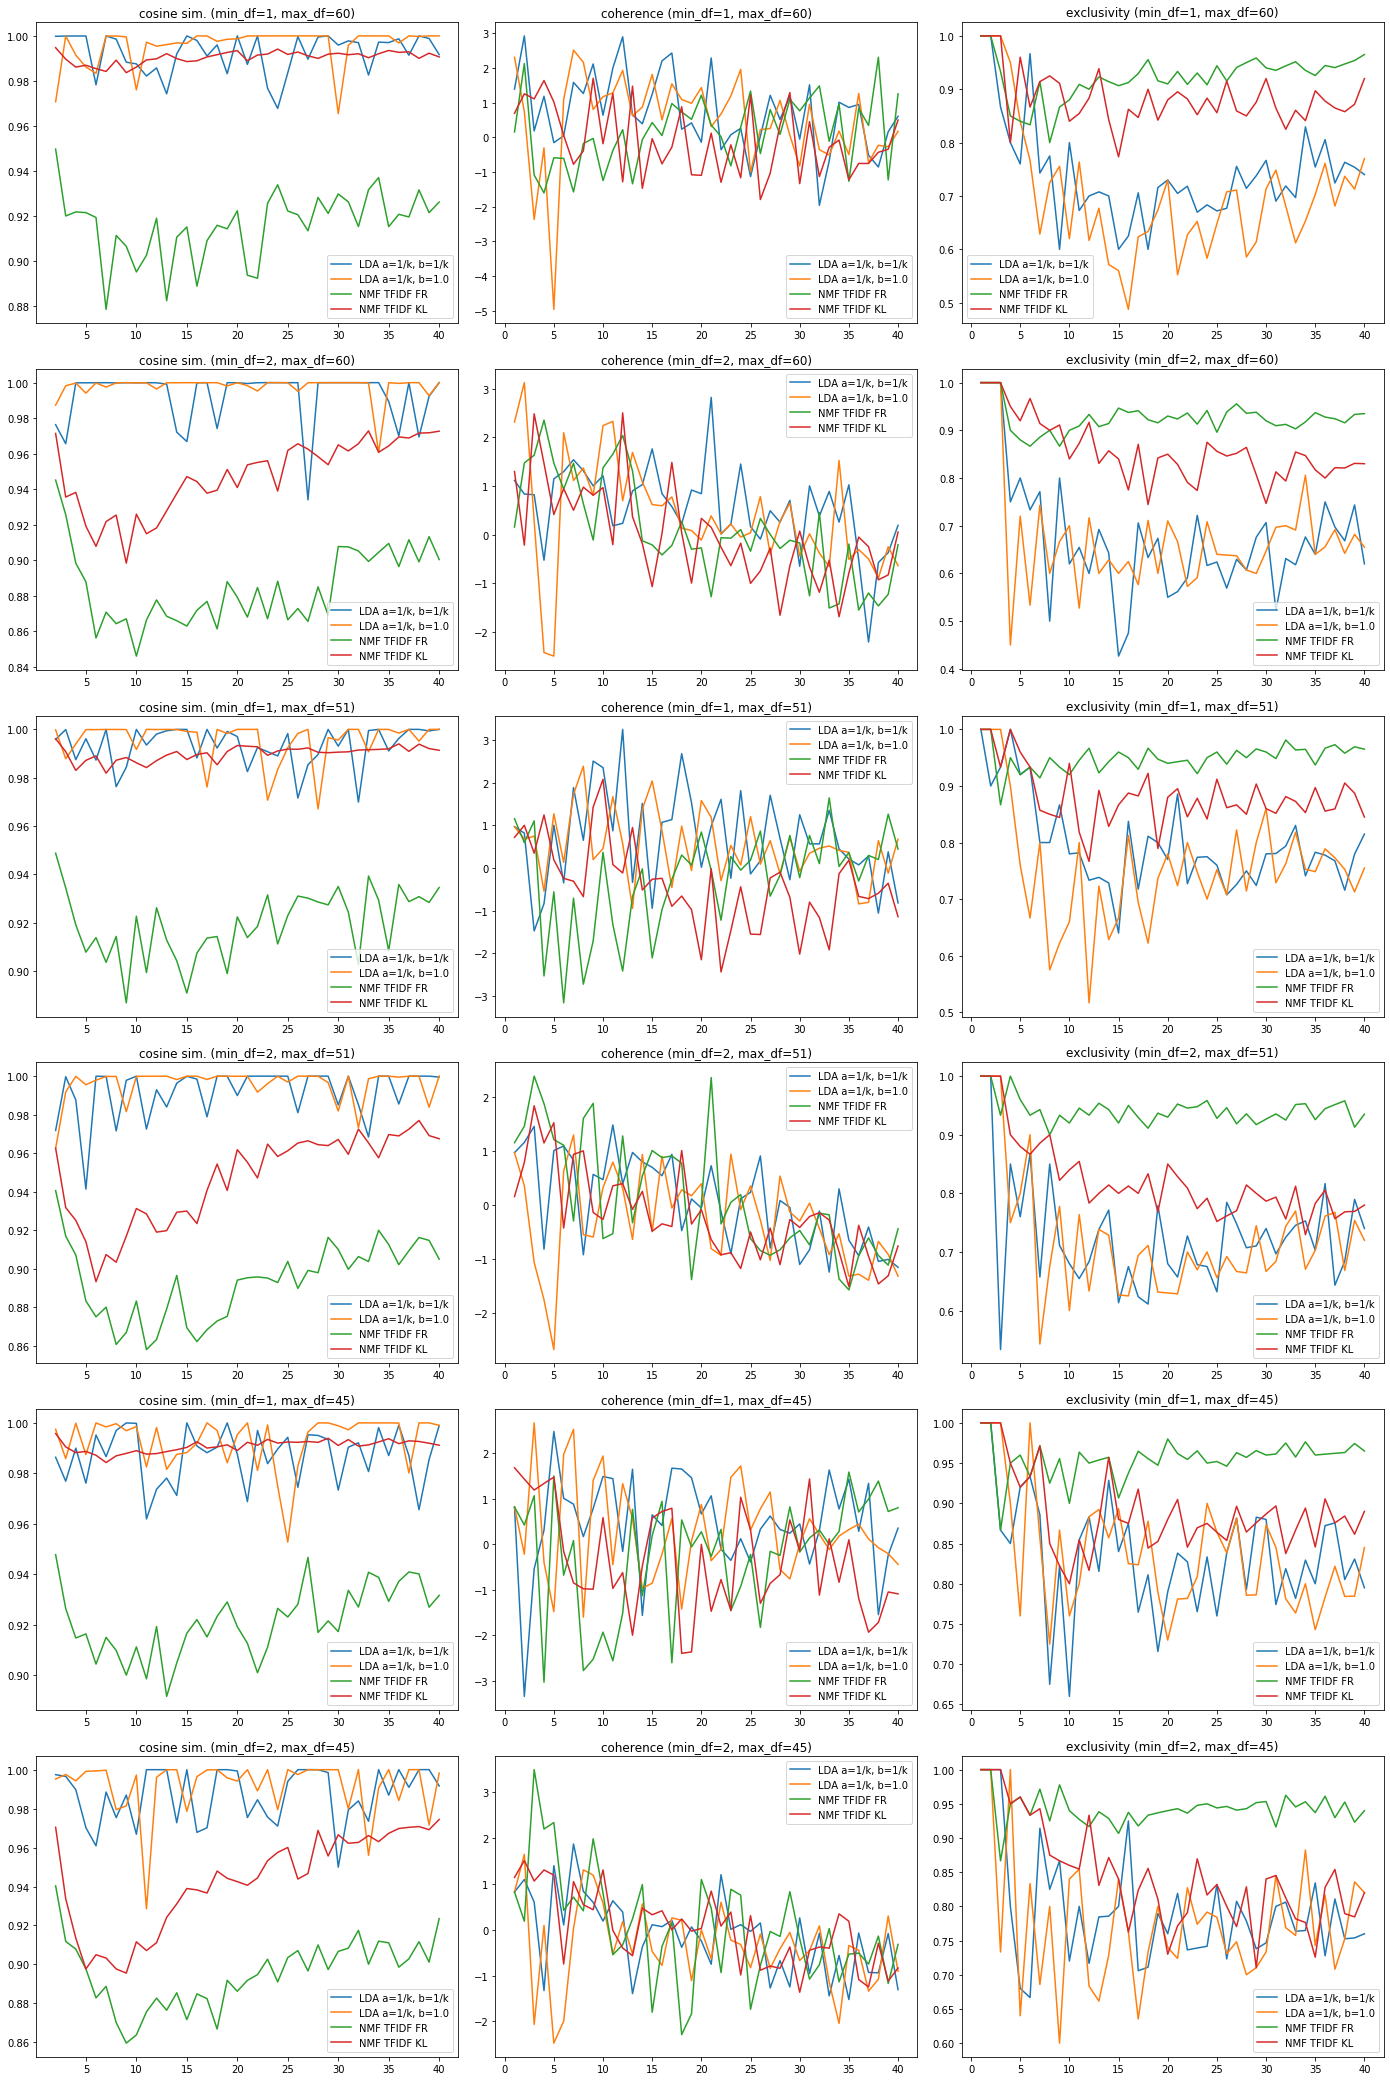

In [84]:
# TUNERS
#max_dfs = [120, 90, 70]
max_dfs = [60, 51, 45]    
min_dfs = [1, 2]
cosine_basis = False
n_topic_min = 1
n_topic_max = 40
n_topic_step = 1 # One doc per transaction

#            folder      model variant     alpha (only LDA)   beta (only LDA)      plot label
models = [['TM_LDA_P',   'lda',               'None',             'None',         'LDA a=1/k, b=1/k'],
          ['TM_LDA_P',   'lda',               'None',              '1.0',         'LDA a=1/k, b=1.0'],
          ['TM_NMF_P',   'nmf_tfidf_fr',       None,               None,          'NMF TFIDF FR'      ],
          ['TM_NMF_P',   'nmf_tfidf_kl',       None,               None,          'NMF TFIDF KL'      ]]
#----------------------------------------------

#evaluate_bestof(max_dfs, min_dfs, models, n_topic_min, n_topic_max, n_topic_step, cosine_basis)